In [1]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn part
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# other models
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor, plot_importance
from catboost import CatBoostRegressor

# others
from scipy.stats import uniform, randint
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Reading the datasets
df_train = pd.read_csv("data/stores_train.csv")
df_test = pd.read_csv("data/stores_test.csv")
df_bus_stops = pd.read_csv("data/busstops_norway_fixed.csv")
df_grunnkrets_age_dist = pd.read_csv("data/grunnkrets_age_distribution.csv")
df_grunnkrets_house_pers = pd.read_csv("data/grunnkrets_households_num_persons.csv")
df_grunnkrets_income_house = pd.read_csv("data/grunnkrets_income_households.csv")
df_grunnkrets_stripped = pd.read_csv("data/grunnkrets_norway_stripped.csv")
df_plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
df_extra = pd.read_csv("data/stores_extra.csv")

In [3]:
# Only select 2016 year
df_grunnkrets_stripped = df_grunnkrets_stripped[df_grunnkrets_stripped.year == 2016]
df_grunnkrets_age_dist = df_grunnkrets_age_dist[df_grunnkrets_age_dist.year == 2016]
df_grunnkrets_house_pers = df_grunnkrets_house_pers[df_grunnkrets_house_pers.year == 2016]
df_grunnkrets_income_house = df_grunnkrets_income_house[df_grunnkrets_income_house.year == 2016]

# EDA

Merge the train/test in one df with a split feature.

In [4]:
df_all = pd.concat([df_train, df_test])
df_all['split'] = np.where(df_all['revenue'].isna(), 'Test', 'Train')
df_all.head()

,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue,split
0,983540538-974187930-44774,2016,MCDONALD'S BRAGERNES TORG MAGASINET,1.1.1.0,Hamburger restaurants,6020303,BRAGERNES TORG 13,59.743104,10.204928,MCDONALDS,Magasinet Drammen,17.998,Train
1,987074191-973117734-44755,2016,MCDONALD'S KLINGENBERGGATA,1.1.1.0,Hamburger restaurants,3010306,NaN,59.913759,10.734031,MCDONALDS,NaN,23.828,Train
2,984890265-981157303-64491,2016,BURGER KING HØNEFOSS,1.1.1.0,Hamburger restaurants,6050102,KONG RINGS GATE 1,60.164751,10.254656,BURGER KING,Kuben Hønefoss,16.099,Train
3,914057442-992924179-126912,2016,BURGER KING GLASSHUSPASSASJEN,1.1.1.0,Hamburger restaurants,18040102,STORGATA 12,67.283669,14.379796,BURGER KING,Glasshuspassasjen,9.296,Train
4,913018583-913063538-668469,2016,BURGER KING TILLERTORGET,1.1.1.0,Hamburger restaurants,16017414,NaN,63.358068,10.374832,BURGER KING,Tillertorget,4.528,Train


In [5]:
print(f"Number of Training Examples = {df_train.shape[0]}")
print(f"Number of Test Examples = {df_test.shape[0]}\n")
print(f"Training Shape = {df_train.shape}")
print(f"Test Shape = {df_test.shape}\n")
print('Train columns \n', list(df_train.columns))
print('Test columns \n', list(df_test.columns))

Number of Training Examples = 12859
Number of Test Examples = 8577

Training Shape = (12859, 12)
Test Shape = (8577, 11)

Train columns 
 ['store_id', 'year', 'store_name', 'plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon', 'chain_name', 'mall_name', 'revenue']
Test columns 
 ['store_id', 'year', 'store_name', 'plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'address', 'lat', 'lon', 'chain_name', 'mall_name']


In [6]:
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12859 entries, 0 to 12858
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   store_id             12859 non-null  object 
 1   year                 12859 non-null  int64  
 2   store_name           12859 non-null  object 
 3   plaace_hierarchy_id  12859 non-null  object 
 4   sales_channel_name   12859 non-null  object 
 5   grunnkrets_id        12859 non-null  int64  
 6   address              11085 non-null  object 
 7   lat                  12859 non-null  float64
 8   lon                  12859 non-null  float64
 9   chain_name           3737 non-null   object 
 10  mall_name            2280 non-null   object 
 11  revenue              12859 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8577 entries, 0 to 8576
Data columns (total 11 columns):
 #   Column      

Text(0.5, 1.0, 'Fraction of rows with NaN values')

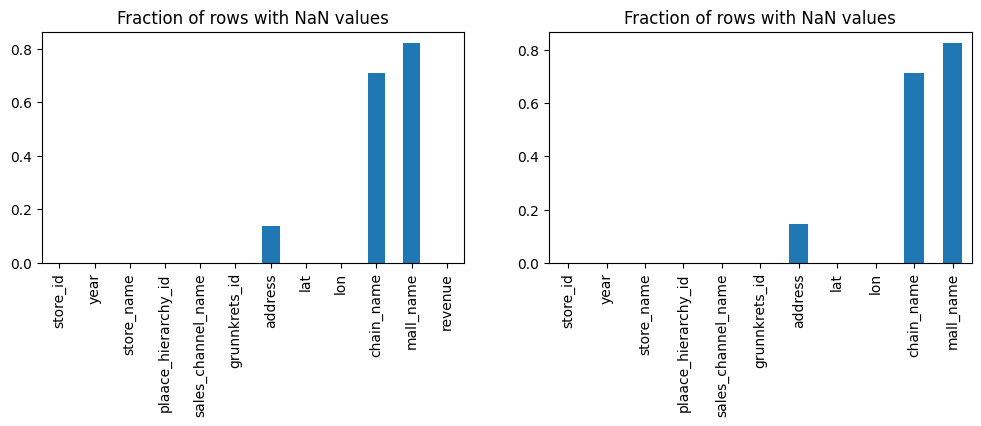

In [7]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 3), ncols=2)
df_train.isna().mean().plot.bar(ax=ax1)
df_test.isna().mean().plot.bar(ax=ax2)
ax1.set_title('Fraction of rows with NaN values')
ax2.set_title('Fraction of rows with NaN values')

The adress feature has 1,774 NaN rows in train & 1237 in test.

The other NaN values are in mall/chain name, which is pretty normal because every store which is not in a chain/mall has probably a NaN value in that column. We could encode these two features to make them usable by replacing the NaN value with a default one.

# Revenue
### We tried to analyze how the revenue is distributed in our dataset and how we can maybe transform it to make better predictions

Minimal revenue is : 0.0
Maximal revenue is : 219.599
Average revenue is : 8.22


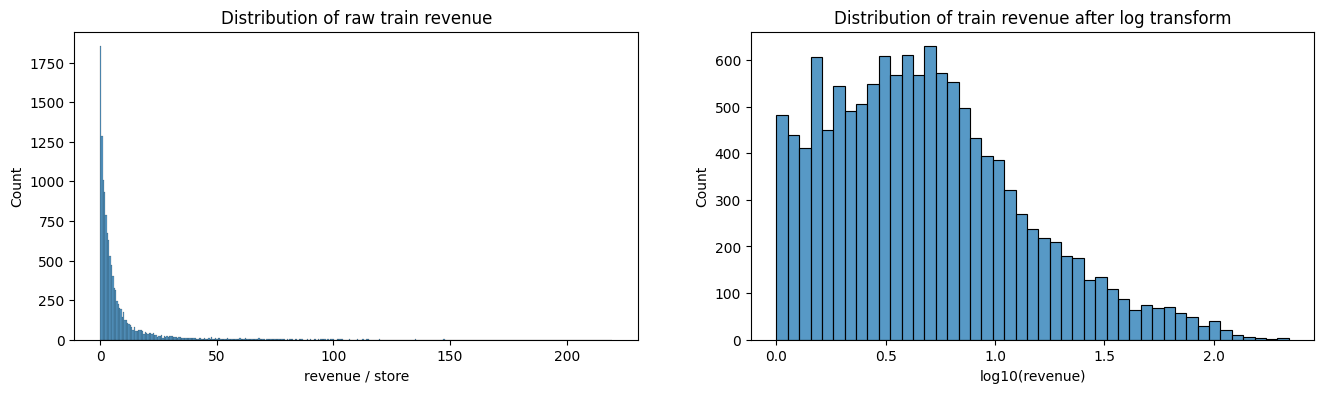

In [8]:
print(f"Minimal revenue is : {df_train['revenue'].min()}")
print(f"Maximal revenue is : {df_train['revenue'].max()}")
print(f"Average revenue is : {round(df_train['revenue'].mean(), 2)}")

fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(df_train.revenue.rename('revenue / store'), ax=ax1)
ax1.set_title('Distribution of raw train revenue');
sns.histplot(np.log10(df_train.revenue + 1).rename('log10(revenue)'), ax=ax2)
ax2.set_title('Distribution of train revenue after log transform');

The maximum revenue is way higher than the average revenue. The median is very low compared to the mean. So we tried to use a log transform to make the revenue more evenly distributed without removing any high revenue shops as outliers. In the end we used a log10 and also experimented with other log transformations for example the log2 for our final submissions. 

In [9]:
# Checking for "outliers"
print(f"Number of revenue 0 : {df_train[df_train.revenue == 0].revenue.count()}")
print(f"Number of revenue > 80 :{df_train[df_train.revenue >= 80].revenue.count()}")

Number of revenue 0 : 217
Number of revenue > 80 :131


Text(0.5, 1.0, 'Sorted revenue')

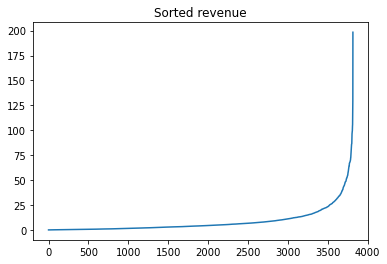

In [10]:
X = df_train[['grunnkrets_id', 'revenue']].groupby('grunnkrets_id').mean().sort_values('revenue')
plt.plot(range(X.shape[0]), np.asarray(X['revenue']))
plt.title("Sorted revenue")

Text(0.5, 1.0, 'Sorted revenue for all shops with revenue < 80')

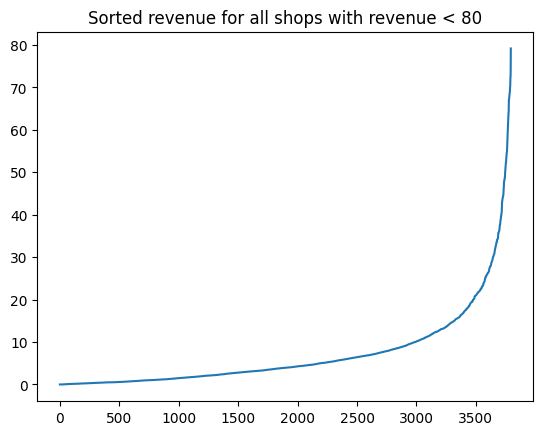

In [10]:
# Seeing if removing the outliers is making the distribution a bit more linear (spoiler not that much)
X = df_train[df_train.revenue < 80][['grunnkrets_id', 'revenue']].groupby('grunnkrets_id').mean().sort_values('revenue')
plt.plot(range(X.shape[0]), np.asarray(X['revenue']))
plt.title("Sorted revenue for all shops with revenue < 80")

Text(0.5, 1.0, 'Log10 transformed revenue in comparison to a linear graph')

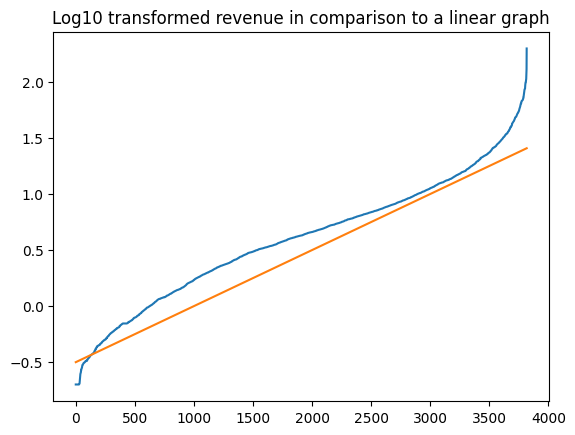

In [11]:
X = df_train[['grunnkrets_id', 'revenue']].groupby('grunnkrets_id').mean().sort_values('revenue')
plt.plot(range(X.shape[0]), np.log10(np.asarray(X['revenue']) + 0.2))
plt.plot(range(X.shape[0]), np.asarray(range(X.shape[0]))*0.0005 - 0.5)
plt.title("Log10 transformed revenue in comparison to a linear graph")

# Chain Name & Mall Name


For the chain & mall name feature, we need to know how we encode it. We first did a basic "if in a chain/mall = 1 else 0".
But having it with a more precise encoding would be better, so let's see how many shop is in each chain/mall

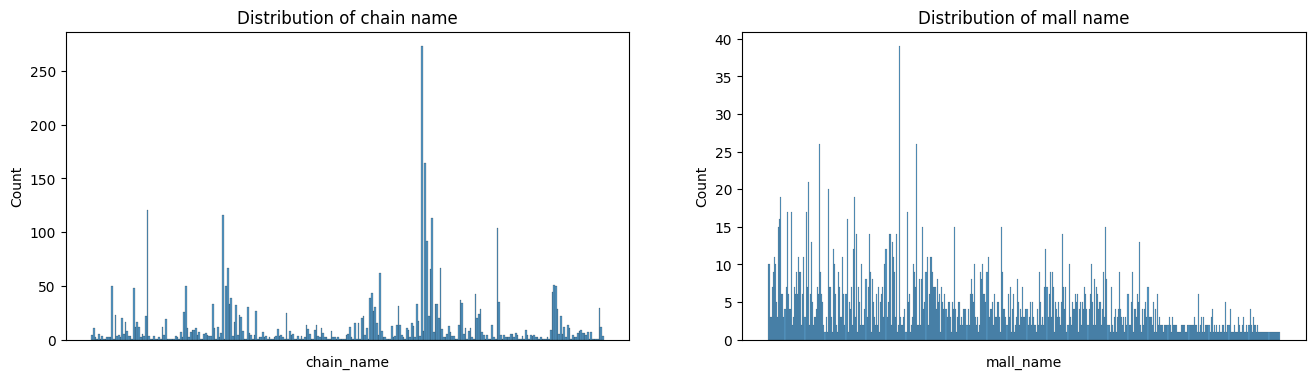

In [175]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
sns.histplot(df_train.chain_name, ax=ax1)
ax1.set_title('Distribution of chain name');
ax1.set(xticklabels=[]);
ax1.tick_params(bottom=False)

sns.histplot(df_train.mall_name, ax=ax2)
ax2.set_title('Distribution of mall name');
ax2.set(xticklabels=[]);
ax2.tick_params(bottom=False)

Encoding mall and chain seems to be considered

In [12]:
# Doing a quick encoding
df_mall_chain = df_train
df_mall_chain['encoded_mall'] = np.where(df_train['mall_name'].isna(), 0, 1)
df_mall_chain['encoded_chain'] = np.where(df_train['chain_name'].isna(), 0, 1)

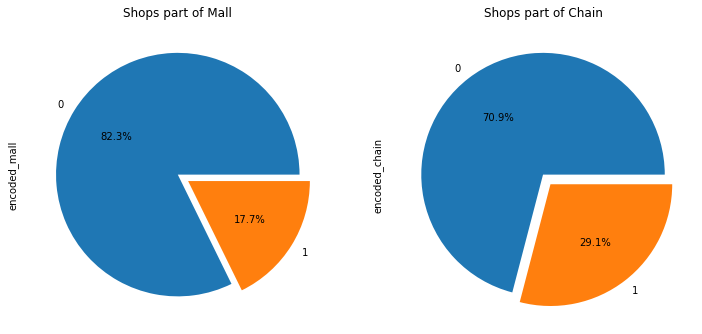

In [16]:
f, ax = plt.subplots(1, 2, figsize=(12,6))
df_mall_chain['encoded_mall'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=False)
df_mall_chain['encoded_chain'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[1],shadow=False)
ax[0].set_title('Shops part of Mall')
ax[1].set_title('Shops part of Chain')
plt.show()

As we can see the majority of shops is not in a chain or a mall. Some malls/chains also have a way higher occurrence than others.  

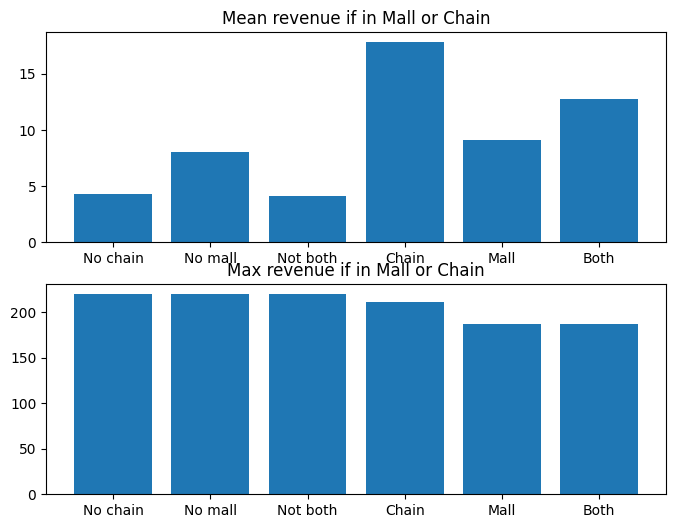

In [177]:
f,(ax1, ax2) = plt.subplots(2, figsize=(8,6))
x = [df_mall_chain[df_mall_chain.encoded_chain == 0].revenue.mean(),
     df_mall_chain[df_mall_chain.encoded_mall == 0].revenue.mean(),
     df_mall_chain[(df_mall_chain.encoded_mall == 0) & (df_mall_chain.encoded_chain == 0)].revenue.mean(),
     df_mall_chain[df_mall_chain.encoded_chain == 1].revenue.mean(),
     df_mall_chain[df_mall_chain.encoded_mall == 1].revenue.mean(),
     df_mall_chain[(df_mall_chain.encoded_mall == 1) & (df_mall_chain.encoded_chain == 1)].revenue.mean(),
    ]       
ax1.bar(np.arange(len(x)), height=x)
ax1.set_xticks(np.arange(len(x)), ['No chain', 'No mall', 'Not both', 'Chain', 'Mall', 'Both']);
ax1.set_title('Mean revenue if in Mall or Chain');

x = [df_mall_chain[df_mall_chain.encoded_chain == 0].revenue.max(),
     df_mall_chain[df_mall_chain.encoded_mall == 0].revenue.max(),
     df_mall_chain[(df_mall_chain.encoded_mall == 0) & (df_mall_chain.encoded_chain == 0)].revenue.max(),
     df_mall_chain[df_mall_chain.encoded_chain == 1].revenue.max(),
     df_mall_chain[df_mall_chain.encoded_mall == 1].revenue.max(),
     df_mall_chain[(df_mall_chain.encoded_mall == 1) & (df_mall_chain.encoded_chain == 1)].revenue.max(),
    ]       
ax2.bar(np.arange(len(x)), height=x)
ax2.set_xticks(np.arange(len(x)), ['No chain', 'No mall', 'Not both', 'Chain', 'Mall', 'Both']);
ax2.set_title('Max revenue if in Mall or Chain');


The chain feature seems to be really important for predicting the revenue because the mean revenue for all shops which are in a chain is way higher than shops that are not in a chain. Shops that are in a mall also have a higher mean revenue than shops that are not in a mall, but only by a small margin.  

# Localisation
We analyzed the localisation of the shops to maybe find areas with a higher revenue than others 

In [178]:
print(f"Minimal lat/lon is : {df_all['lat'].min()} | {df_all['lon'].min()}")
print(f"Maximal lat/lon is : {df_all['lat'].max()} | {df_all['lon'].max()}")
print(f"Average lat/lon is : {round(df_all['lat'].mean(), 2)} | {round(df_all['lon'].mean(), 2)}")

Minimal lat/lon is : 57.99418282682979 | 4.62588949001731
Maximal lat/lon is : 71.1099216326422 | 31.11893463
Average lat/lon is : 61.23 | 10.01


We should take in consideration the shift between the X and Y axis during our preprocessing.

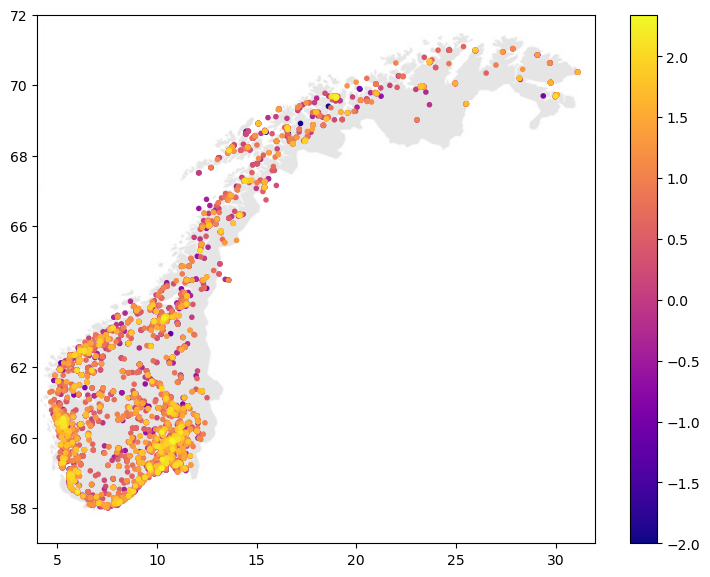

In [26]:
df_map = df_train.sort_values(by='revenue', ascending=True)
backdrop = plt.imread('ressources/map.jpg')
plt.figure(figsize=(9, 7), dpi=100)
ax = plt.gca()
ax.imshow(backdrop, 
          extent=[4,32, 57, 72], 
          aspect='auto', 
          alpha=0.2,
          )
cmap = np.log10(df_map.revenue + 0.01)
heatmap = ax.scatter(x=df_map['lon'], 
                     y=df_map['lat'], 
                     c=cmap,
                     cmap='plasma',
                     marker=".",
                     )
ax.set_xlim(4, 32)    # min/max longitude of image 
ax.set_ylim(57, 72)  # min/max latitude of image
cbar = plt.colorbar(heatmap)

In the popular cities/regions are a lot more high revenue shops than for example in the north of Norway. 

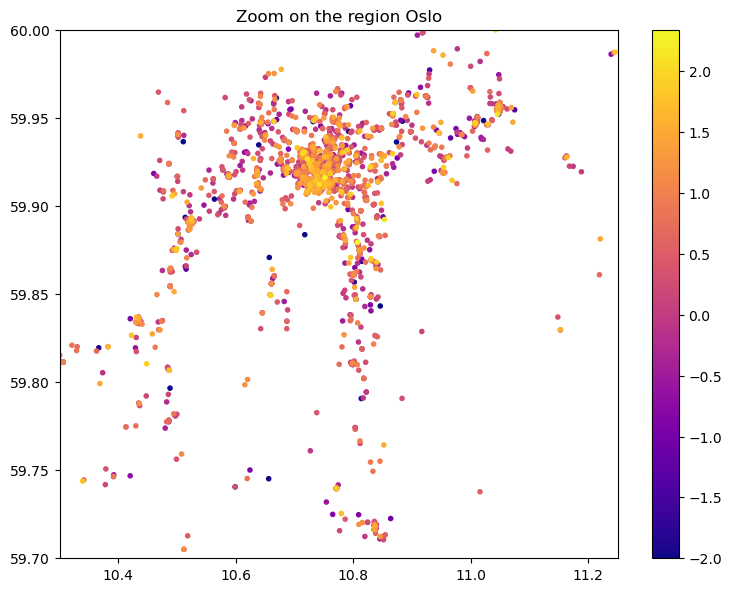

In [29]:
def plot_restricted_area(min_lon, max_lon, min_lat, max_lat):
    area = df_train[(df_train.lon>min_lon) & (df_train.lon<max_lon) & (df_train.lat>min_lat) & (df_train.lat<max_lat)]
    area = area.sort_values(by='revenue', ascending=True)
    backdrop = plt.imread('ressources/map.jpg')
    plt.figure(figsize=(9, 7), dpi=100)
    ax = plt.gca()
    heatmap = ax.scatter(x=area['lon'], 
               y=area['lat'], 
               c=np.log10(area.revenue + 0.01),
               cmap='plasma',
               marker=".",
               )
    ax.set_xlim(min_lon, max_lon)    # min/max longitude of image 
    ax.set_ylim(min_lat, max_lat)  # min/max latitude of image
    ax.set_title("Zoom on the region Oslo")
    
    cbar = plt.colorbar(heatmap)

# Olso
plot_restricted_area(10.3, 11.25, 59.7, 60)
# North random campaign
# plot_restricted_area(29, 32, 69, 71)

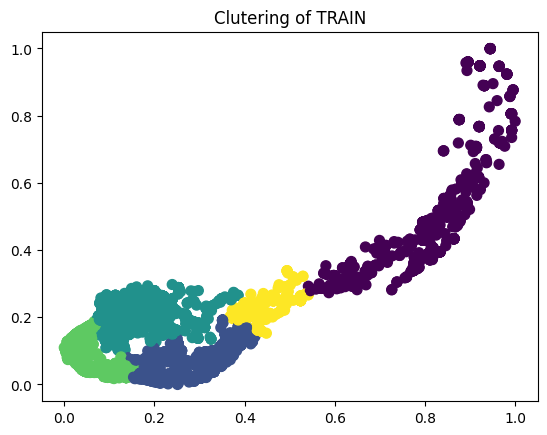

In [119]:
# Trying to cluster in some region to maybe correlate something
X = df_train.loc[:, ['lat', 'lon']]
X['lat'] = X.lat * 11.112
X['lon'] = X.lon * 6.4757
scaler = MinMaxScaler(feature_range=(0, 1))
X[X.columns] = scaler.fit_transform(X)
agglo = AgglomerativeClustering(n_clusters=5)
plt.scatter(X['lat'], X['lon'], c=agglo.fit_predict(X), s=50, cmap='viridis')
plt.title('Clutering of TRAIN')
plt.show()

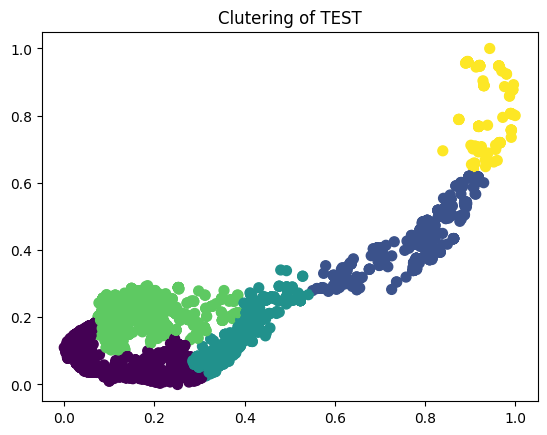

In [120]:
X = df_test.loc[:, ['lat', 'lon']]
X['lat'] = X.lat * 11.112
X['lon'] = X.lon * 6.4757
scaler = MinMaxScaler(feature_range=(0, 1))
X[X.columns] = scaler.fit_transform(X)
agglo = AgglomerativeClustering(n_clusters=5)
plt.scatter(X['lat'], X['lon'], c=agglo.fit_predict(X), s=50, cmap='viridis')
plt.title('Clutering of TEST')
plt.show()

We used clustering methods to find regions which we could use for feature engineering but in the end we just used the municipalities from the data provided.

## Generation of the data
### Splitting of the data

It could be helpful to understand how the data has been generated.

So let's first see if the data train and test has been splitted in a certain percentage for each grunnkret.

Text(0.5, 1.0, 'Location of shops in train and test')

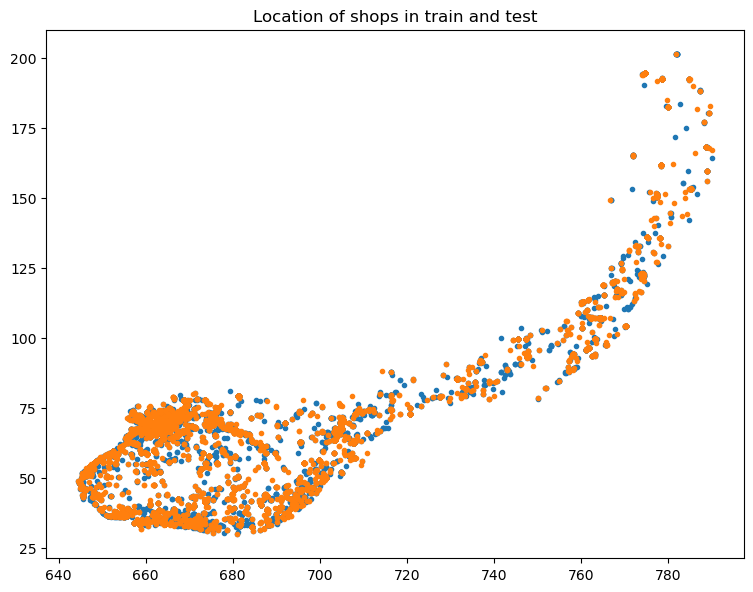

In [32]:
df_map_train = df_train.loc[:, ['lat', 'lon']]
df_map_train['lat'] = df_map_train.lat * 11.112
df_map_train['lon'] = df_map_train.lon * 6.4757
df_map_train = df_map_train.sort_values(by=['lat', 'lon'], ascending=True)


df_map_test = df_test.loc[:, ['lat', 'lon']]
df_map_test['lat'] = df_map_test.lat * 11.112
df_map_test['lon'] = df_map_test.lon * 6.4757
df_map_test = df_map_test.sort_values(by=['lat', 'lon'], ascending=True)

plt.figure(figsize=(9, 7), dpi=100)
plt.scatter(df_map_train['lat'], df_map_train['lon'], marker=".",)
plt.scatter(df_map_test['lat'], df_map_test['lon'], marker=".",)
plt.title("Location of shops in train and test")

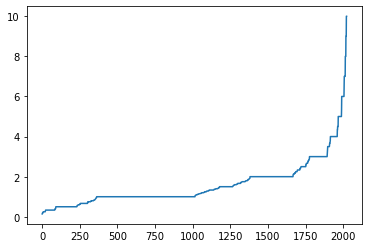

In [31]:
X = pd.DataFrame(df_train[['grunnkrets_id']].value_counts(), columns=['count'])
Y = pd.DataFrame(df_test[['grunnkrets_id']].value_counts(), columns=['count'])
total = pd.merge(X, Y, how="left", on="grunnkrets_id").fillna(0)
total['%'] = total.count_x / total.count_y
total = total.sort_values('%')
plt.plot(range(total.shape[0]), total['%'])


In [136]:
print(len(df_train['grunnkrets_id'].unique()), len(df_test['grunnkrets_id'].unique()))

3817 3161


Despite a pretty intuitive homogeneous distribution among Norway, we can't conclude over a split by each grunnkret.

The distribution of the location of the stores in train and test seems to be pretty similar, so we could not find a indicator how the data was generated there. 

### Generation of the Store ID

When we explored the features we also had a look at the store id. As raw values, the id doesn't reveal anything, but it could be somehow useful (especially after trying a lot of things).

So let's try so to split it at every "-" to get three usable parts in the end.

row with non digit id Empty DataFrame
Columns: [store_id, SI_p1, SI_p2, SI_p3]
Index: [] Empty DataFrame
Columns: [store_id, SI_p1, SI_p2, SI_p3]
Index: [] Empty DataFrame
Columns: [store_id, SI_p1, SI_p2, SI_p3]
Index: []
number of unique value per parts 12859 12859 12859
len of the part per part 9.0 8.930476708919823 5.481141612878139


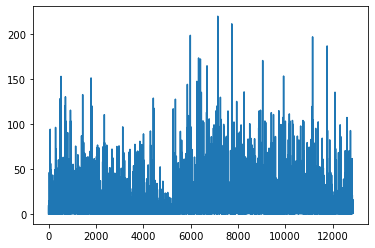

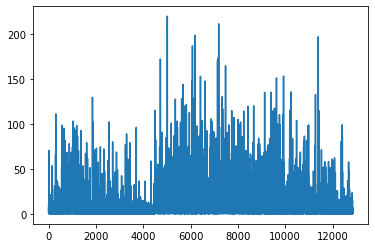

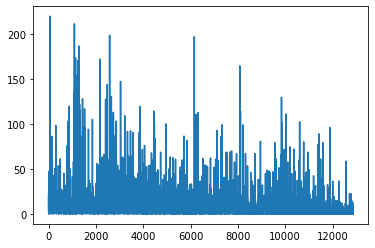

In [33]:
tmp_df = df_train.loc[:, ['store_id',]]
tmp_df[['SI_p1', 'SI_p2', 'SI_p3']] = df_train['store_id'].str.extract(r'(?P<p1>[0-9]+)-+(?P<p2>[0-9]+)-+(?P<p3>[0-9]+)',expand=True)
# Checking the composition of the parts, all digits ?
print('row with non digit id', tmp_df[~tmp_df.SI_p1.str.isdigit()], tmp_df[~tmp_df.SI_p2.str.isdigit()], tmp_df[~tmp_df.SI_p3.str.isdigit()])

tmp_df['len_p1'] = tmp_df['SI_p1'].str.len()
tmp_df['len_p2'] = tmp_df['SI_p2'].str.len()
tmp_df['len_p3'] = tmp_df['SI_p3'].str.len()
tmp_df[['SI_p1', 'SI_p2', 'SI_p3']] = tmp_df[['SI_p1', 'SI_p2', 'SI_p3']].apply(pd.to_numeric)
# All unique values ?
print('number of unique value per parts', len(tmp_df.SI_p1.unique()), len(tmp_df.SI_p1.unique()), len(tmp_df.SI_p1.unique()))
tmp_df = pd.merge(tmp_df, df_train[['revenue', 'store_id']], on='store_id', how='left')
# Is it the same length ?
print('len of the part per part', tmp_df['len_p1'].mean(), tmp_df['len_p2'].mean(), tmp_df['len_p3'].mean())
# Any correlation with the price
plt.plot(range(tmp_df.shape[0]), np.asarray(tmp_df.sort_values('SI_p1')['revenue']))
plt.show()
plt.plot(range(tmp_df.shape[0]), np.asarray(tmp_df.sort_values('SI_p2')['revenue']))
plt.show()
plt.plot(range(tmp_df.shape[0]), np.asarray(tmp_df.sort_values('SI_p3')['revenue']))
plt.show()

All of them are numbers and unique values. 

We also plotted the individual parts of the store id with the revenue and it seems like the first and second part have a really similar distribution.

Despite some 'outliers' we can guess a certain distribution which could be useful in our prediction.

# External Data

We now take a look at the external data given.

## Bus Stop

The bus stop dataframe can't be merged directly with our other dataframes. So we need to find a way for it.

One way could be to find how many bus_stop is in each grunnkrets with the geometry specification.

In [35]:
geometries = np.asarray(df_grunnkrets_stripped.geometry)
print("Different kind of shapes from the grunnkrets are :", set([geometry[:geometry.find('(')] for geometry in geometries]))
# So the grunnkret are one polygon or multiple ones, so we can try to find if a bus stop is contained in it

Different kind of shapes from the grunnkrets are : {'POLYGON', 'MULTIPOLYGON'}


There is also some different categories for the bus stop that need to be check

In [36]:
print("Number of unique importance level :", len(df_bus_stops.importance_level.unique()))
print(df_bus_stops.importance_level.unique())

# {'Mangler viktighetsnivå': 0, 'Standard holdeplass': 1, 'Lokalt knutepunkt': 2, 'Regionalt knutepunkt': 3, 'Nasjonalt knutepunkt': 4, 'Annen viktig holdeplass': 5}
# ['Missing importance level', 'Default stop', 'Local hub', 'Regional hub', 'National hub', 'Other important stop']

Number of unique importance level : 6
['Mangler viktighetsnivå' 'Standard holdeplass' 'Lokalt knutepunkt'
 'Nasjonalt knutepunkt' 'Regionalt knutepunkt' 'Annen viktig holdeplass']


### Amount of bus stop by grunnkrets
A function has been made, but for our final models we don't use it, and it take 20 min to run so whatever we don't put it here.
Here we just imagine that the dataframe df_grunnkrets_bus_count is containing a a column grunnkrets_id according to the grunnkret where the bus stop is.
Creating the dataframe with grunnkret_id and the amount of bus station in it

In [37]:
df_grunnkrets_bus_count = df_grunnkrets_stripped.loc[:, ['grunnkrets_id',]]
df_grunnkrets_bus_count = df_bus_stops.groupby(['grunnkrets_id', 'importance_level']).size().unstack(fill_value=0).replace(np.nan, 0)
df_grunnkrets_bus_count = df_grunnkrets_bus_count.drop(0)
df_grunnkrets_bus_count = df_grunnkrets_bus_count.rename(columns={'Mangler viktighetsnivå': 'missing_impt',
                                                                  'Standard holdeplass': 'strandard_bus',
                                                                  'Lokalt knutepunkt': 'local_bus',
                                                                  'Regionalt knutepunkt': 'regional_bus',
                                                                  'Nasjonalt knutepunkt': 'national_bus',
                                                                  'Annen viktig holdeplass': 'other_impt'})

# amount_bus_stop = df_grunnkrets_bus_count['grunnkrets_id'].map(df_bus_stop_count)
# df_grunnkrets_bus_count['amount_bus_stop'] = amount_bus_stop
# df_grunnkrets_bus_count['amount_bus_stop'] = df_grunnkrets_bus_count['amount_bus_stop'].replace(np.nan, 0)
df_grunnkrets_bus_count

importance_level,other_impt,local_bus,missing_impt,national_bus,regional_bus,strandard_bus
grunnkrets_id,,,,,,
1010102,0,0,2,0,0,0
1010103,0,0,13,0,0,0
1010104,0,1,9,0,0,0
1010105,0,1,12,0,1,0
1010107,0,2,4,0,0,1
...,...,...,...,...,...,...
20300306,0,0,3,0,0,0
20300310,0,0,3,0,0,1
20300311,0,0,3,0,0,0


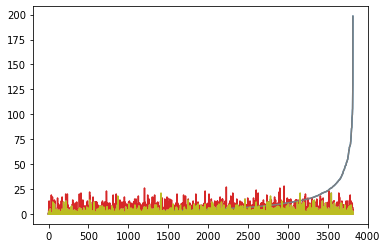

In [38]:
# print(f"Minimal bus stops is : {df_grunnkrets_bus_count['amount_bus_stop'].min()}")
# print(f"Maximal bus stops is : {df_grunnkrets_bus_count['amount_bus_stop'].max()}")
# print(f"Average bus stops is : {round(df_grunnkrets_bus_count['amount_bus_stop'].mean(), 2)}")
X = df_train[['grunnkrets_id', 'revenue']].groupby('grunnkrets_id').mean().sort_values('revenue')
X = pd.merge(X, df_grunnkrets_bus_count, on="grunnkrets_id", how="left").fillna(0)
for column in [
    'revenue',
    'other_impt',
    'local_bus',
    'missing_impt',
    'national_bus',
    'regional_bus',
    'strandard_bus'
]:
    plt.plot(range(X.shape[0]), np.asarray(X[column]))

plt.plot(range(X.shape[0]), np.asarray(X['revenue']))
plt.plot(range(X.shape[0]), np.asarray(X[['other_impt', 'local_bus', 'national_bus', 'regional_bus', 'strandard_bus']].sum(axis=1)))

# fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
# sns.histplot(df_grunnkrets_bus_count.amount_bus_stop.rename(' amount grunnkret / amount_bus_stop '), ax=ax1)
# ax1.set_title('Distribution of bus stops in grunnkrets');
# sns.histplot(df_train.groupby('grunnkrets_id')['revenue'].agg([np.min, np.max, np.mean])['mean'].rename('revenue / grunnkret'), ax=ax2)
# ax2.set_title('Distribution of revenue in grunnkret');

Here every cureve is plotted, but even by looking each at the time, the number of bus stop per grunnkret doesn't link to the mean revenue of it at alL;

So we plotted the different importance levels to find a correlation to the revenue but we could not find anything at all.

## Grunnkrets

Drawing the grunnkrets map to see how the stripped_grunnkrets dataframe is covering the Norway map

0.0 %
1.8842327404280976 %
3.7684654808561953 %
5.652698221284293 %
7.5369309617123905 %
9.421163702140488 %
11.305396442568586 %
13.189629182996685 %
15.073861923424781 %
16.95809466385288 %
18.842327404280976 %
20.726560144709076 %
22.610792885137172 %
24.49502562556527 %
26.37925836599337 %
28.263491106421466 %
30.147723846849562 %
32.03195658727766 %
33.91618932770576 %
35.800422068133855 %
37.68465480856195 %
39.56888754899005 %
41.45312028941815 %
43.33735302984625 %
45.221585770274345 %
47.10581851070244 %
48.99005125113054 %
50.874283991558634 %
52.75851673198674 %
54.642749472414835 %
56.52698221284293 %
58.41121495327103 %
60.295447693699124 %
62.17968043412722 %
64.06391317455532 %
65.94814591498341 %
67.83237865541152 %
69.71661139583962 %
71.60084413626771 %
73.48507687669581 %
75.3693096171239 %
77.253542357552 %
79.1377750979801 %
81.0220078384082 %
82.9062405788363 %
84.7904733192644 %
86.6747060596925 %
88.55893880012059 %
90.44317154054869 %
92.32740428097678 %
94.211

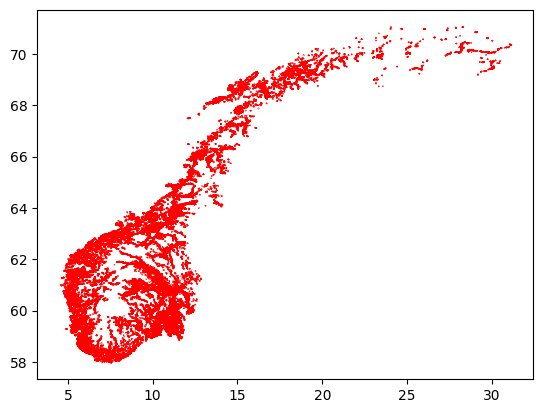

In [41]:
from shapely.wkt import loads
from shapely.geometry import Polygon, MultiPolygon

from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection


def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

geometries = [loads(geometry) for geometry in np.asarray(df_grunnkrets_stripped['geometry'])]

fig, ax = plt.subplots()
for idx, geometry in enumerate(geometries):
    if type(geometry) is MultiPolygon:
        for element in geometry.geoms:
            plot_polygon(ax, element, edgecolor='red')
    else:
        plot_polygon(ax, geometry, edgecolor='red')
    if idx % 500 == 0:
        print(idx*100/len(geometries), "%")
plt.show()

Not all the map is defined by a grunnkret so maybe we are going to have some missing values during the merging.

## Age distribution

The age distribution can allow us to retrieve how many persons are living in each grunnkret, and we can split them in by categories such as youngs, adults, senios.

In [23]:
df_grunnkrets_age_dist.head()

,grunnkrets_id,year,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,...,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_89,age_90
0,16013117,2015,14,14,14,14,13,13,12,11,...,0,0,0,0,0,0,0,0,0,0
1,16013117,2016,10,10,10,10,10,10,9,9,...,0,0,0,0,0,0,0,0,0,0
2,11030206,2015,5,5,5,5,5,4,4,3,...,0,0,0,0,0,0,0,0,0,0
3,16011203,2016,2,2,2,2,2,3,3,3,...,1,1,1,1,1,1,1,0,0,0
4,3011601,2016,7,7,7,7,6,6,5,4,...,1,1,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Mean revenue per grunkret and population of each grunkret')

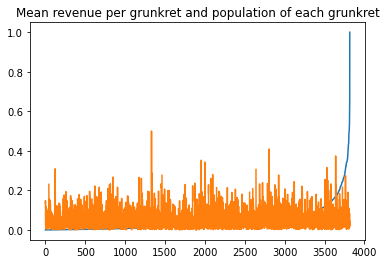

In [39]:
population_grunnnkrets = df_grunnkrets_age_dist.loc[:, ['grunnkrets_id']]
population_grunnnkrets['population'] = df_grunnkrets_age_dist.iloc[:,2:92].sum(axis=1)
X = df_train[['grunnkrets_id', 'revenue']]
X = df_train[['grunnkrets_id', 'revenue']].groupby('grunnkrets_id').mean().sort_values('revenue')
X = pd.merge(X, population_grunnnkrets, on="grunnkrets_id", how="left")

scaler = MinMaxScaler(feature_range = (0, 1))
X[X.columns] = scaler.fit_transform(X)
plt.plot(range(X.shape[0]), np.asarray(X['revenue']))
plt.plot(range(X.shape[0]), np.asarray(X['population'])/2)
plt.title("Mean revenue per grunkret and population of each grunkret")

Apparently there is no clear correlation between the mean revenue in a grunnkret and the population. 

## Income

Text(0.5, 1.0, 'Mean revenue per grunnkret and income per grunnkret')

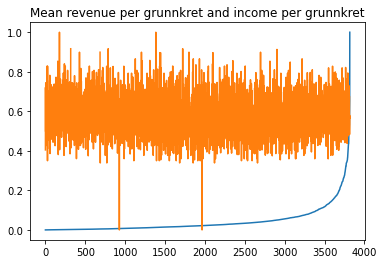

In [40]:
income_grunnnkrets = df_grunnkrets_income_house.loc[:, ['grunnkrets_id', 'all_households']]
X = df_train[['grunnkrets_id', 'revenue']]
X = df_train[['grunnkrets_id', 'revenue']].groupby('grunnkrets_id').mean().sort_values('revenue')
X = pd.merge(X, income_grunnnkrets, on="grunnkrets_id", how="left")
scaler = MinMaxScaler(feature_range = (0, 1))
X[X.columns] = scaler.fit_transform(X)
plt.plot(range(X.shape[0]), np.asarray(X['revenue']))
plt.plot(range(X.shape[0]), np.asarray(X['all_households']))
plt.title("Mean revenue per grunnkret and income per grunnkret")

Apparently there is also no correlation between the income and the revenue

## Grunnkret Stripped

In [41]:
print("Number of unique district name :", len(df_grunnkrets_stripped.district_name.unique()))
print("Number of unique district name :", len(df_grunnkrets_stripped.municipality_name.unique()))

Number of unique district name : 1483
Number of unique district name : 422


Text(0.5, 1.0, 'Area and revenue')

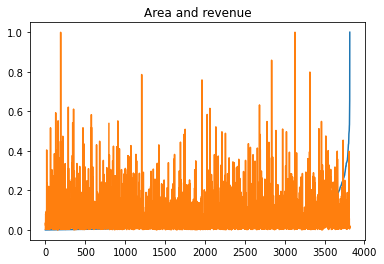

In [43]:
income_grunnnkrets = df_grunnkrets_stripped.loc[:, ['grunnkrets_id', 'area_km2']]
X = df_train[['grunnkrets_id', 'revenue']]
X = df_train[['grunnkrets_id', 'revenue']].groupby('grunnkrets_id').mean().sort_values('revenue')
X = pd.merge(X, income_grunnnkrets, on="grunnkrets_id", how="left")
scaler = MinMaxScaler(feature_range = (0, 1))
X[X.columns] = scaler.fit_transform(X)
plt.plot(range(X.shape[0]), np.asarray(X['revenue']))
plt.plot(range(X.shape[0]), np.asarray(X['area_km2']))
plt.title("Area and revenue")

There is no correlation between the area of a grunnkret and the mean revenue per grunnkret

##  Hierarchy

Text(0.5, 1.0, 'lv4')

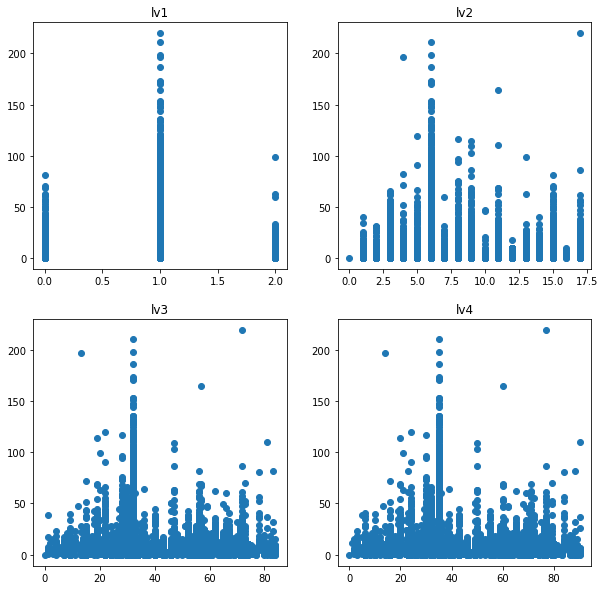

In [64]:
df_plot = pd.merge(df_train, df_plaace_hierarchy, how="left", on="plaace_hierarchy_id")
le = LabelEncoder()
#df_train[['revenue']]
df_plot = df_plot[["lv1_desc", "lv2_desc", "lv3_desc", "lv4_desc", "revenue"]]
df_plot["lv1_desc"] = le.fit_transform(df_plot["lv1_desc"])
df_plot["lv2_desc"] = le.fit_transform(df_plot["lv2_desc"])
df_plot["lv3_desc"] = le.fit_transform(df_plot["lv3_desc"])
df_plot["lv4_desc"] = le.fit_transform(df_plot["lv4_desc"])
fig, ax = plt.subplots(2,2, figsize = (10,10))
ax[0, 0].scatter(df_plot["lv1_desc"], df_plot.revenue)
ax[0, 0].set_title("lv1")
ax[0, 1].scatter(df_plot["lv2_desc"], df_plot.revenue)
ax[0, 1].set_title("lv2")
ax[1, 0].scatter(df_plot["lv3_desc"], df_plot.revenue)
ax[1, 0].set_title("lv3")
ax[1, 1].scatter(df_plot["lv4_desc"], df_plot.revenue)
ax[1, 1].set_title("lv4")

Most of the hierarchy categories seem to have a high range of different revenues. But some of the categories give a clear indicator for the revenue of the shops in this hierarchy level. 

## Correlation Matrix

Let's make a big dataframe with all the features given and merged together.

And let's see how many missing values with have.

In [65]:
X = df_train.loc[:, ['store_name', 'plaace_hierarchy_id', 'sales_channel_name', 'grunnkrets_id', 'lat', 'lon', 'revenue']]

df_grunnkrets_population = df_grunnkrets_age_dist.loc[:, ['grunnkrets_id']]
df_grunnkrets_population['total_population'] = df_grunnkrets_age_dist.iloc[:,2:92].sum(axis=1)
df_grunnkrets_population['youngs'] = df_grunnkrets_age_dist.iloc[:,2:20].sum(axis=1)
df_grunnkrets_population['adults'] = df_grunnkrets_age_dist.iloc[:,21:64].sum(axis=1)
df_grunnkrets_population['seniors'] = df_grunnkrets_age_dist.iloc[:,65:92].sum(axis=1)

df_grunnkrets_bus_count = df_grunnkrets_stripped.loc[:, ['grunnkrets_id',]]
df_grunnkrets_bus_count = df_bus_stops.groupby(['grunnkrets_id', 'importance_level']).size().unstack(fill_value=0).replace(np.nan, 0)
df_grunnkrets_bus_count = df_grunnkrets_bus_count.drop(0)
df_grunnkrets_bus_count = df_grunnkrets_bus_count.rename(columns={'Mangler viktighetsnivå': 'missing_impt', 
                                                                  'Standard holdeplass': 'strandard_bus',
                                                                  'Lokalt knutepunkt': 'local_bus',
                                                                  'Regionalt knutepunkt': 'regional_bus',
                                                                  'Nasjonalt knutepunkt': 'national_bus',
                                                                  'Annen viktig holdeplass': 'other_impt'})


X = pd.merge(X, df_grunnkrets_population, on="grunnkrets_id", how="left")
X = pd.merge(X, df_grunnkrets_house_pers[['grunnkrets_id', 'couple_children_0_to_5_years', 'couple_children_18_or_above', 'couple_children_6_to_17_years', 'couple_without_children', 'single_parent_children_0_to_5_years', 'single_parent_children_18_or_above', 'single_parent_children_6_to_17_years', 'singles']], on="grunnkrets_id", how="left")
X = pd.merge(X, df_grunnkrets_income_house[['grunnkrets_id', 'all_households', 'singles', 'couple_without_children', 'couple_with_children', 'other_households', 'single_parent_with_children']], on="grunnkrets_id", how="left")
X = pd.merge(X, df_grunnkrets_stripped[['grunnkrets_id', 'district_name', 'municipality_name', 'area_km2']], on="grunnkrets_id", how="left")
X = pd.merge(X, df_grunnkrets_bus_count, on="grunnkrets_id", how="left")
X = pd.merge(X, df_plaace_hierarchy[['plaace_hierarchy_id', 'lv3_desc', 'lv4_desc']], on="plaace_hierarchy_id", how="left")

X = X.drop(['plaace_hierarchy_id'], axis=1)

<AxesSubplot:>

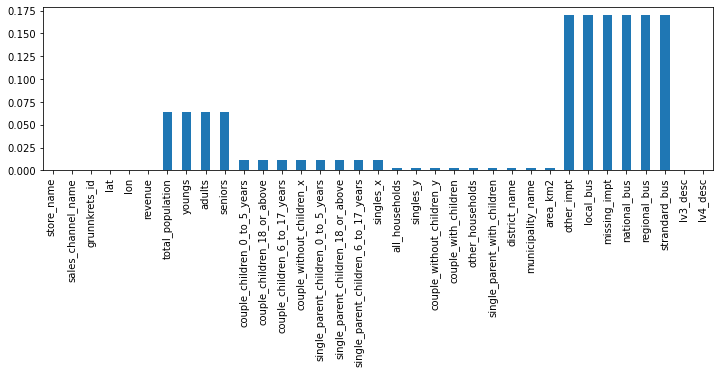

In [66]:
fig, ax1 = plt.subplots(figsize=(12, 3))
X.isna().mean().plot.bar(ax=ax1)

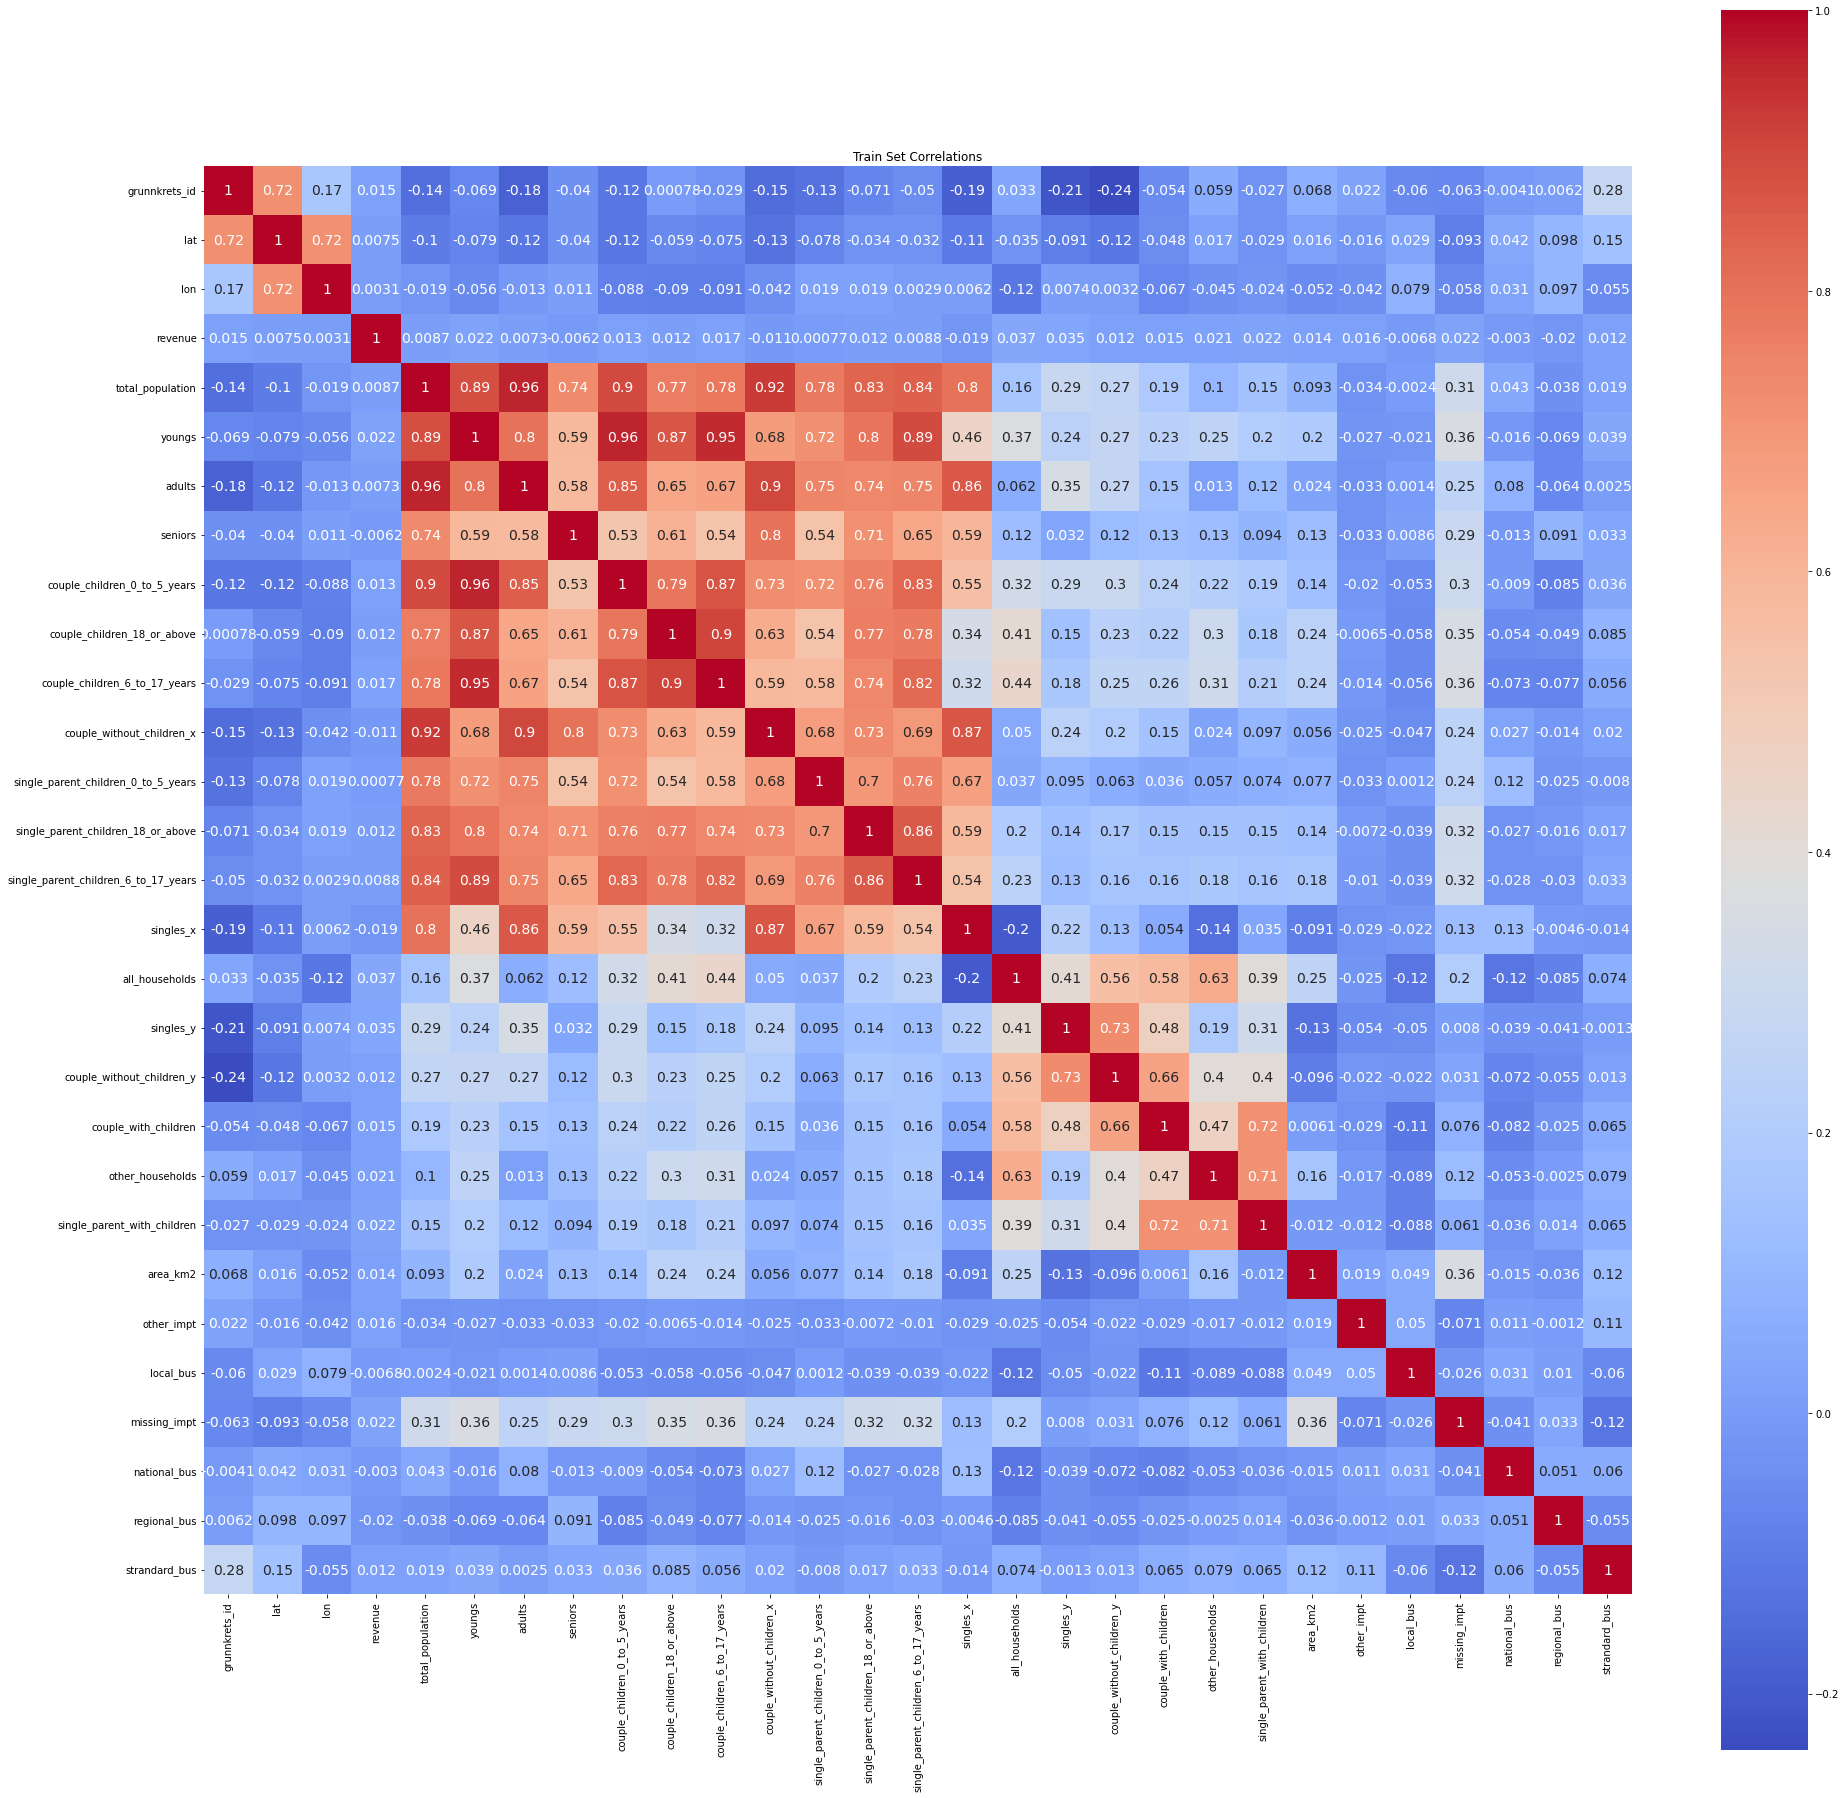

In [67]:
fig, axs = plt.subplots(figsize=(32, 32))

sns.heatmap(X.corr(), ax=axs, annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
#sns.heatmap(stores_test.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
    
axs.tick_params(axis='x', labelsize=10)
axs.tick_params(axis='y', labelsize=10)
    
axs.set_title('Train Set Correlations', size=12)
#axs[1].set_title('Test Set Correlations', size=12)

plt.show()

We created a correlation matrix for all the features to see which features have a high correlation with the revenue. There is no feature which is clearly correlated to the revenue. We also used the matrix to find highly correlated features because we do not want to put correlated features in our models. If we have highly correlated features in our model, they do more or less the same thing and just make the model unnecessarily complex. They maybe even lead to a worse result. 

# Feature Engineering & Preprocessing

We created a function to remove outliers from the train set by using the z-score and we scaled the lat/lon values to the same level to do distance computations. In the end we did not use the outlier removal because the "outlier" values seem to be important to get a good prediction

In [4]:
def remove_outliers(df):
    # df = df[df.revenue != 0]
    # df = df[df.revenue >= 80]
    # df = df.drop(df[df.revenue <= df.revenue.quantile(.03)].index)
    # df = df.drop(df[df.revenue >= df.revenue.quantile(1 - .04)].index)
    upper = df.revenue.mean() + 3*df.revenue.std()
    lower = df.revenue.mean() - 3*df.revenue.std()
    df = df.drop(df[df.revenue > upper].index)
    df = df.drop(df[df.revenue < lower].index)
    return df


def fix_lat_lon(df):
    df['lat_processed'] = df.lat * 11.112
    df['lon_processed'] = df.lon * 6.4757
    return df

Below you can find all our functions for creating the different dataframes which we merge with the train and test data. Besides that we created a function to find the nearest bus stops for every shop and we imputed the missing values in municipality names. 

In [5]:
def fix_year(df):
    return df[df.year == 2016]


def create_population_repartition(df_grunnkrets_house_pers):
    tmp = df_grunnkrets_house_pers[[
            'grunnkrets_id',
            'couple_children_0_to_5_years',
            'couple_children_6_to_17_years',
            'couple_children_18_or_above',
            'couple_without_children',
            'single_parent_children_0_to_5_years',
            'single_parent_children_6_to_17_years',
            'single_parent_children_18_or_above',
            'singles'
        ]]
    return tmp.rename({column: 'hp_' + column for column in tmp.columns if column != 'grunnkrets_id'}, axis=1)


def create_income_repartition(df_grunnkrets_income_house):
    tmp = df_grunnkrets_income_house[[
            'grunnkrets_id',
            'all_households',
            'singles',
            'couple_without_children',
            'couple_with_children',
            'other_households',
            'single_parent_with_children'
            ]]
    return tmp.rename({column: 'ih_' + column for column in tmp.columns if column != 'grunnkrets_id'}, axis=1)


def create_grunnkret_geodata(df_grunnkrets_stripped):
    return df_grunnkrets_stripped[[
                            'grunnkrets_id',
                            'area_km2',
                            'municipality_name'
                            ]]


def create_hierarchy(df_plaace_hierarchy):
    return df_plaace_hierarchy[[
                            'plaace_hierarchy_id',
                            'lv1_desc',
                            'lv2_desc',
                            'lv3_desc'
                            ]]


def create_population_age(df_grunnkrets_age_dist):
    df_grunnkrets_population = df_grunnkrets_age_dist.loc[:, ['grunnkrets_id']]
    df_grunnkrets_population['total_population'] = df_grunnkrets_age_dist.iloc[:,2:92].sum(axis=1)
    df_grunnkrets_population['youngs'] = df_grunnkrets_age_dist.iloc[:, 2:20].sum(axis=1)
    df_grunnkrets_population['adults'] = df_grunnkrets_age_dist.iloc[:, 21:64].sum(axis=1)
    df_grunnkrets_population['seniors'] = df_grunnkrets_age_dist.iloc[:, 65:92].sum(axis=1)
    return df_grunnkrets_population


def find_closest_bus_stop(df, df_bus_stops):
    """
    Combine the training data with the bus stop data by finding :
    - the closest bus stop from the store (create a feature the minimal distance then)
    - the mean distance of every bus stop in 1km radius
    for each category of bus stop
    """
    df['lat_processed'] = df.lat_processed * 10
    df['lon_processed'] = df.lon_processed * 10

    categories = ['Mangler viktighetsnivå',
                  'Standard holdeplass',
                  'Lokalt knutepunkt',
                  'Nasjonalt knutepunkt',
                  'Regionalt knutepunkt',
                  'Annen viktig holdeplass']

    new_bs_features = pd.DataFrame(df.store_id)

    df_bus_tmp = df_bus_stops.loc[:, ['busstop_id']]
    df_bus_tmp[['lon_processed', 'lat_processed']] = df_bus_stops['geometry'].str.extract(
        r'(?P<lat>[0-9]*[.]?[0-9]+)\s(?P<lon>[0-9]*[.]?[0-9]+)', expand=True)
    df_bus_tmp['lon_processed'] = pd.to_numeric(df_bus_tmp['lon_processed']) * 6.4757 * 10  # value in km
    df_bus_tmp['lat_processed'] = pd.to_numeric(df_bus_tmp['lat_processed']) * 11.112 * 10  # value in km

    mat = cdist(df_bus_tmp[['lat_processed', 'lon_processed']], df[['lat_processed', 'lon_processed']], metric='euclidean')
    correlation_dist = pd.DataFrame(mat, index=df_bus_tmp['busstop_id'], columns=df['store_id'])
    new_bs_features = pd.merge(new_bs_features,
                               pd.DataFrame(correlation_dist.min(),
                                            columns=['BS_closest']),
                               on='store_id', how='left')
    new_bs_features = pd.merge(new_bs_features,
                               pd.DataFrame(correlation_dist[correlation_dist < 1].mean(),
                                            columns=['BS_mean_1km']),
                               on='store_id', how='left')
    new_bs_features = pd.merge(new_bs_features,
                               pd.DataFrame(correlation_dist[correlation_dist < 0.5].count(),
                                                columns=['number_BS_500m']), on='store_id')

    for category in categories:
        df_bus_tmp = df_bus_stops[df_bus_stops['importance_level'] == category].loc[:, ['busstop_id']]
        df_bus_tmp[['lon_processed', 'lat_processed']] = df_bus_stops['geometry'].str.extract(
                                                                r'(?P<lat>[0-9]*[.]?[0-9]+)\s(?P<lon>[0-9]*[.]?[0-9]+)',
                                                                expand=True)
        df_bus_tmp['lon_processed'] = pd.to_numeric(df_bus_tmp['lon_processed']) * 6.4757 * 10    # value in km
        df_bus_tmp['lat_processed'] = pd.to_numeric(df_bus_tmp['lat_processed']) * 11.112 * 10    # value in km

        mat = cdist(df_bus_tmp[['lat_processed', 'lat_processed']], df[['lat_processed', 'lon_processed']], metric='euclidean')
        correlation_dist = pd.DataFrame(mat, index=df_bus_tmp['busstop_id'], columns=df['store_id'])
        new_bs_features = pd.merge(new_bs_features,
                                   pd.DataFrame(correlation_dist.min(),
                                                columns=['BS_closest_' + category.lower().replace(' ', '_')]),
                                   on='store_id', how='left')
        new_bs_features = pd.merge(new_bs_features,
                                   pd.DataFrame(correlation_dist[correlation_dist < 1].mean(),
                                                columns=['BS_mean_1km_'+category.lower().replace(' ', '_')]),
                                   on='store_id', how='left')
    return new_bs_features.fillna(0)


def fix_municipalities(current_df):
    # Get the rows with missing municipality
    df_missing_mun = current_df[current_df["municipality_name"].isna()]
    # Create a copy of the current df and drop row where mun = NaN + Reset index
    current_df_copy = current_df.copy().dropna(subset=['municipality_name'])
    current_df_copy = current_df_copy.reset_index(drop=True)
    # For each missing municipality
    for index, row in df_missing_mun.iterrows():
        # Create a df with the the difference with the loc of the current store and all the others stores
        tmp_df = pd.concat([current_df_copy.loc[:, ["lat_processed"]] - row.lat_processed,
                            current_df_copy.loc[:, ["lon_processed"]] - row.lon_processed], axis=1)
        # Find the idx of the one with the smallest error (the closest from the other)
        idx = np.argmin(np.linalg.norm(tmp_df.to_numpy(), axis=1))
        # Retrieve the municipality of the closest one and input it in the missing one
        current_df.loc[index, "municipality_name"] = current_df_copy.loc[idx, "municipality_name"]
    return current_df


In [6]:
def label_uniformier(array_train, array_test):
    """
    Take the unique values from the train and test part to combine it in a single array.
    Useful to fit the label encoder and don't do a mess during the transform (previously fit_transform that was confusing)
    """
    label_encoder = LabelEncoder()
    labels = np.asarray(list(array_train.unique()) + list(set(array_test.unique()) - set(array_train.unique())))
    label_encoder.fit(labels)
    return label_encoder

In [7]:
def encode_feature(df_train, df_test, feature_name):
    """
    Encode categorical features to numerical values with the label uniformier
    """
    le = label_uniformier(df_train[feature_name], df_test[feature_name])
    df_train['encoded_' + feature_name] = le.transform(df_train[feature_name])
    df_test['encoded_' + feature_name] = le.transform(df_test[feature_name])
    return df_train, df_test

In [8]:
def fill_nan_mean(current_df):
    """
    Fill NaN values with mean for every column
    """
    return current_df.apply(lambda x: x.fillna(x.mean()), axis=0)

In [9]:
def store_secret_feature(df):
    """
    Split of the store_id into three parts(as described in the EDA) to get three features
    """
    tmp_df = df.loc[:, ['store_id', ]]
    tmp_df[['SI_p1', 'SI_p2', 'SI_p3']] = df['store_id'].str.extract(r'(?P<p1>[0-9]+)-+(?P<p2>[0-9]+)-+(?P<p3>[0-9]+)', expand=True)
    tmp_df['SI_all'] = tmp_df[['SI_p1', 'SI_p2', 'SI_p3']].stack().groupby(level=0).apply(''.join)
    tmp_df[['SI_p1', 'SI_p2', 'SI_p3']] = tmp_df[['SI_p1', 'SI_p2', 'SI_p3']].apply(pd.to_numeric)
    tmp_df['SI_all'] = tmp_df['SI_all'].astype('float')
    return tmp_df

In [10]:
def lat_lon_precisionless(df):
    """
    Reducing precision of the lat/lon variable by removing the numbers after the decimal point
    """
    tmp_df = df.loc[:, ['store_id', 'lat', 'lon']]
    tmp_df[['lat', 'lon']] = tmp_df[['lat', 'lon']]
    tmp_df[['lat_reduced', 'lon_reduced']] = tmp_df[['lat', 'lon']].astype('int')
    return tmp_df[['store_id', 'lat_reduced', 'lon_reduced']]


In [11]:
def scale_values(df_train, df_test, Y_train):
    """
    Scaling feature values by using the StandardScaler and using a log transform on the revenue
    """
    scaler = StandardScaler()
    df_train[df_train.columns] = scaler.fit_transform(df_train)
    df_test[df_train.columns] = scaler.transform(df_test)

    scaler = StandardScaler()
    Y_train = np.log10(Y_train + 1)
    # Y_train = scaler.fit_transform(Y_train)

    return df_train, df_test, Y_train, scaler

In [12]:
def extract_revenue(df_train):
    """
    Extracting revenue from the DataFrame
    """
    return df_train.loc[:, ['revenue', ]], df_train.drop(['revenue'], axis=1)

In [13]:
def features_engineering(df_train, df_test):
    """
    Using all the functions from above to create our dataframe for the models
    """
    df_bus_stops = pd.read_csv("../data/busstops_norway.csv")
    df_grunnkrets_age_dist = pd.read_csv("../data/grunnkrets_age_distribution.csv")
    df_grunnkrets_house_pers = pd.read_csv("../data/grunnkrets_households_num_persons.csv")
    df_grunnkrets_income_house = pd.read_csv("../data/grunnkrets_income_households.csv")
    df_grunnkrets_stripped = pd.read_csv("../data/grunnkrets_norway_stripped.csv")
    df_plaace_hierarchy = pd.read_csv("../data/plaace_hierarchy.csv")

    df_grunnkrets_stripped = fix_year(df_grunnkrets_stripped)
    df_grunnkrets_age_dist = fix_year(df_grunnkrets_age_dist)
    df_grunnkrets_house_pers = fix_year(df_grunnkrets_house_pers)
    df_grunnkrets_income_house = fix_year(df_grunnkrets_income_house)

    #Creating the store_id feature
    df_train = pd.merge(df_train, store_secret_feature(df_train), how="left", on="store_id")
    df_test = pd.merge(df_test, store_secret_feature(df_test), how="left", on="store_id")

    #Creating lat/lon with reduced precision
    df_train = pd.merge(df_train, lat_lon_precisionless(df_train), how="left", on="store_id")
    df_test = pd.merge(df_test, lat_lon_precisionless(df_test), how="left", on="store_id")
    #Putting lat/lon in one feature
    df_train['latxlat'] = df_train['lat_reduced']*df_train['lon_reduced']
    df_test['latxlat'] = df_test['lat_reduced']*df_test['lon_reduced']

    df_train = pd.merge(df_train, create_population_repartition(df_grunnkrets_house_pers), how="left", on="grunnkrets_id")
    df_test = pd.merge(df_test, create_population_repartition(df_grunnkrets_house_pers), how="left", on="grunnkrets_id")

    df_train = pd.merge(df_train, create_income_repartition(df_grunnkrets_income_house), how="left",on="grunnkrets_id")
    df_test = pd.merge(df_test, create_income_repartition(df_grunnkrets_income_house), how="left", on="grunnkrets_id")

    df_train = pd.merge(df_train, create_hierarchy(df_plaace_hierarchy), how="left", on="plaace_hierarchy_id")
    df_test = pd.merge(df_test, create_hierarchy(df_plaace_hierarchy), how="left", on="plaace_hierarchy_id")

    df_train = pd.merge(df_train, create_grunnkret_geodata(df_grunnkrets_stripped), how="left", on="grunnkrets_id")
    df_test = pd.merge(df_test, create_grunnkret_geodata(df_grunnkrets_stripped), how="left", on="grunnkrets_id")

    df_train = pd.merge(df_train, create_population_age(df_grunnkrets_age_dist), how="left", on="grunnkrets_id")
    df_test = pd.merge(df_test, create_population_age(df_grunnkrets_age_dist), how="left", on="grunnkrets_id")

    #Creating the population density by using total_population / area_km2
    df_train["population_density"] = df_train["total_population"] / df_train["area_km2"]
    df_test["population_density"] = df_test["total_population"] / df_test["area_km2"]

    df_train = pd.merge(df_train, find_closest_bus_stop(df_train, df_bus_stops), how="left", on="store_id")
    df_test = pd.merge(df_test, find_closest_bus_stop(df_test, df_bus_stops), how="left", on="store_id")

    df_train['mall_name'] = df_train['mall_name'].fillna('0')
    df_test['mall_name'] = df_test['mall_name'].fillna('0')
    df_train, df_test = encode_feature(df_train, df_test, 'mall_name')

    df_train['chain_name'] = df_train['chain_name'].fillna('0')
    df_test['chain_name'] = df_test['chain_name'].fillna('0')
    df_train, df_test = encode_feature(df_train, df_test, 'chain_name')

    df_train, df_test = encode_feature(df_train, df_test, 'sales_channel_name')

    df_train, df_test = encode_feature(df_train, df_test, 'lv3_desc')
    df_train, df_test = encode_feature(df_train, df_test, 'lv2_desc')
    df_train, df_test = encode_feature(df_train, df_test, 'lv1_desc')

    df_train = fix_municipalities(df_train)
    df_test = fix_municipalities(df_test)
    df_train, df_test = encode_feature(df_train, df_test, 'municipality_name')

    Y_train, df_train = extract_revenue(df_train)

    df_train = drop_non_use_features(df_train)
    df_test = drop_non_use_features(df_test)

    X_train = fill_nan_mean(df_train)
    X_test = fill_nan_mean(df_test)

    X_train, X_test, Y_train, scaler_revenue = scale_values(X_train, X_test, Y_train)

    return X_train, X_test, Y_train, scaler_revenue

# Models

In [15]:
#Fixing Seed
SEED = 42

df_train = pd.read_csv("../data/stores_train.csv")
df_test = pd.read_csv("../data/stores_test.csv")

# Preprocessing
df_train = fix_lat_lon(df_train) 
df_test = fix_lat_lon(df_test)

# Features engineering
X_train, X_test, Y_train, scaler_revenue = features_engineering(df_train, df_test)

In [16]:
rf_model = RandomForestRegressor(
    n_estimators=180,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=14,
    min_samples_leaf=11,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    max_leaf_nodes=300,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    random_state=SEED,
)

lgbm_model = LGBMRegressor(
    num_leaves=70,
    max_depth=7, 
    n_estimators=2000,
    min_data_in_leaf = 400,
    learning_rate=0.05,
    random_state=SEED,  
)

xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=300, 
    colsample_bytree=0.8958238323555624, 
    gamma=0.11909139052336326,
    learning_rate=0.05983241782780355,
    subsample=0.8889067727422637,
    max_depth=5,
    random_state=SEED,
)

gb_model = GradientBoostingRegressor(
    random_state=SEED,
)

cb_model = CatBoostRegressor(
    learning_rate=0.1,
    depth=10,
    iterations=100,
    random_state=SEED,
    silent=True
)

C:\Users\janni\anaconda3\envs\scipy\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


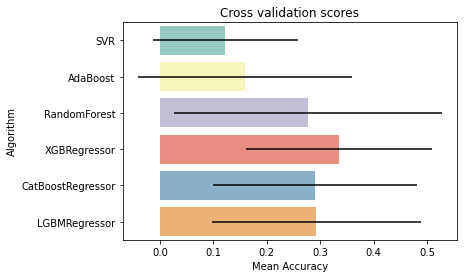

In [22]:
regressors = []
regressors.append(SVR())
regressors.append(AdaBoostRegressor(random_state=SEED))
regressors.append(rf_model)
#regressors.append(GradientBoostingRegressor(random_state=random_state))
#regressors.append(KNeighborsRegressor())
regressors.append(xgb_model)
regressors.append(cb_model)
regressors.append(lgbm_model)


cv_results = []
for regressor in regressors:
    cv_results.append(cross_val_score(regressor, X_train, y = np.ravel(Y_train), cv = KFold(5), n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVR","AdaBoost",
"RandomForest","XGBRegressor","CatBoostRegressor","LGBMRegressor"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

To get an idea how our models are performing we ran them in a KFold on the train data to get a performance indicator. We also submitted them individually to get a real score for our models on the test set. After applying these methods we choose our main models which are LGBM, XGBoost, Random Forest and CatBoost. 

### Feature Selection

To get a general idea which features are more important than others, we used the function above to plot the feature importances for every model. After we selected the better features, we used the plot importance functions from the individual models to finetune our feature selection.

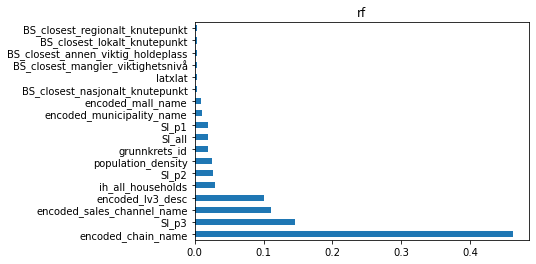

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


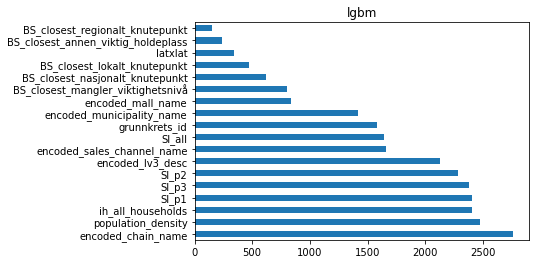

C:\Users\janni\anaconda3\envs\scipy\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


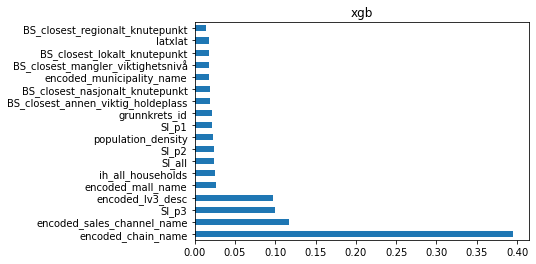

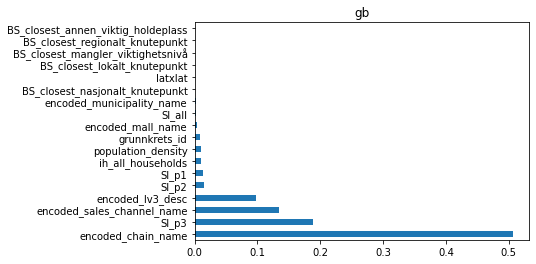

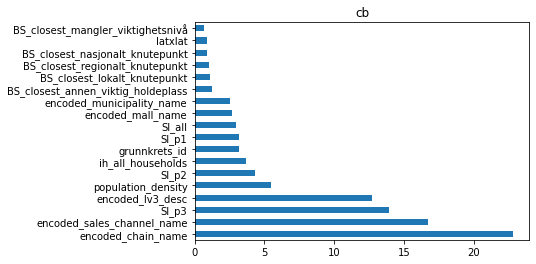

In [26]:
models = {
    'rf': rf_model,
    'lgbm': lgbm_model,
    'xgb': xgb_model,
    'gb': gb_model,
    'cb': cb_model,
}

for key in models:
    plt.title(key)
    model = models[key]
    model.fit(X_train, np.ravel(Y_train))
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feat_importances.nlargest(X_train.shape[0]).plot(kind='barh')
    plt.show()
    
#Functions for finetuning:
#lgbm_model.plot_importance()
#plot_importance(xgb_model)

In [45]:
#features that we ended up using the end
features =   [
    'grunnkrets_id',
    'SI_p1',
    'SI_p2', 
    'SI_p3', 
    'SI_all',
    'latxlat',
    'population_density',
    'ih_all_households',
    'BS_closest_mangler_viktighetsnivå',
    'BS_closest_lokalt_knutepunkt',
    'BS_closest_nasjonalt_knutepunkt',
    'BS_closest_regionalt_knutepunkt',
    'BS_closest_annen_viktig_holdeplass',
    'encoded_lv3_desc',
    'encoded_sales_channel_name',
    'encoded_chain_name',
    'encoded_mall_name',
    'encoded_municipality_name',
]

X_train = keep_only_use_features(X_train, features)
X_test = keep_only_use_features(X_test, features)

In [48]:
lgbm_model.fit(X_train, np.ravel(Y_train))
xgb_model.fit(X_train, np.ravel(Y_train))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8958238323555624,
             enable_categorical=False, gamma=0.11909139052336326, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05983241782780355, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.8889067727422637, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

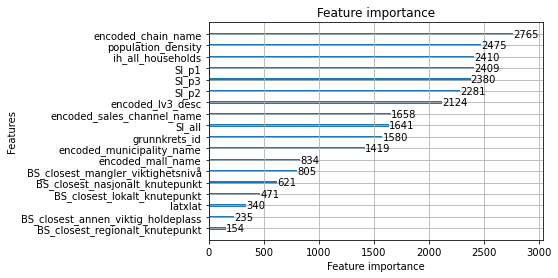

In [51]:
plot_importance(lgbm_model)

### Summary of our submissions

In the beginning we used Random Forest as our first model with only 5 basic features from the standard train dataset. The only thing we did was some missing value imputation. This scored us a 0.82.  
Apparently we did some mistakes in the encoding which lead to worse results but we found our mistake and fixed the encoding. Our score moved to 0.75.  
After that we started to add new features by feature engineering and optimizing our feature selection. We started to use LGBM, XGBoost and CatBoost and created a mean Ensemble model which lead to us to a score of 0.70  
Then we got kind of stuck at that mark and started to go back to feature engineering and data analysis, because hyperparameter tuning did not really improved our results significantly.   
In the end we found new features and started using a Meta Model to increase our accuracy. This resulted in our final score of 0.67.

# Hyperparameter Tuning

We used different methods for hyperparameter tuning, we used GridSearch & RandomizedSearchCV.

We also used manual tuning by trying different parameters and checking our score in combination with a k-fold cross validation.

The code for the tuning can be seen below.

### Warning: Code is not runnable

In [ ]:
param_distributions = {
    #put parameters here e.g "n_estimators": [10,50,100] 
}
search_cv = RandomizedSearchCV(
    #put model here, 
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=20, random_state=0, n_jobs=2
)
search_cv.fit(X_train,np.ravel(Y_train))

columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

# Submissions

### Ensemble Mean Model RandomForest, LGBM, XGBoost with log10 revenue

In [28]:
rf_model.fit(X_train, np.ravel(Y_train))
lgbm_model.fit(X_train, np.ravel(Y_train))
xgb_model.fit(X_train, np.ravel(Y_train))

rf_prediction = rf_model.predict(X_test)
lgbm_prediction = lgbm_model.predict(X_test)
xgb_prediction = xgb_model.predict(X_test)

avg_prediction = np.mean([
    rf_prediction,
    lgbm_prediction,
    xgb_prediction,
], axis=0)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


C:\Users\janni\anaconda3\envs\scipy\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [30]:
submission = pd.DataFrame()
submission['id'] = df_test.store_id 
submission['predicted'] = np.asarray(10 ** avg_prediction - 1)
submission.to_csv('submission1.csv', index=False)
submission.head()

,id,predicted
0,914206820-914239427-717245,1.893921
1,916789157-916823770-824309,2.972328
2,913341082-977479363-2948,6.140530
3,889682582-889697172-28720,8.846818
4,997991699-998006945-417222,4.635479


### Ensemble Meta Model RandomForest, LGBM, XGBoost with log10 revenue 

In [31]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

# oof = out of fold
def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 3 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.iloc[train_index, :]
        y_tr = y_train[train_index]
        x_te = x_train.iloc[test_index, :]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [32]:
rf_oof_train, rf_oof_test = get_oof(rf_model, X_train, np.ravel(Y_train), X_test)
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_model, X_train, np.ravel(Y_train), X_test)
xgb_oof_train, xgb_oof_test = get_oof(xgb_model, X_train, np.ravel(Y_train), X_test)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


C:\Users\janni\anaconda3\envs\scipy\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [33]:
x_train = np.concatenate((
    rf_oof_train,
    lgbm_oof_train,
    xgb_oof_train,
), axis=1)

x_test = np.concatenate((
    rf_oof_test,
    lgbm_oof_test,
    xgb_oof_test,
), axis=1)

In [34]:
# OOF predictions
meta_df = pd.DataFrame(x_train, columns=[
    'RF',
    'LGBM',
    'XGB',
])
meta_df['label'] = Y_train

In [35]:
META_MODEL = LinearRegression()
META_MODEL.fit(x_train, Y_train)
Y_Pred = META_MODEL.predict(x_test)

In [39]:
submission = pd.DataFrame()
submission['id'] = df_test.store_id 
submission['predicted'] = np.asarray(10 ** Y_Pred - 1)
submission.to_csv('submission2.csv', index=False)
submission.head()

,id,predicted
0,914206820-914239427-717245,1.895336
1,916789157-916823770-824309,3.201257
2,913341082-977479363-2948,5.825307
3,889682582-889697172-28720,8.838633
4,997991699-998006945-417222,4.782184


### Ensemble Meta Model RandomForest, LGBM, XGBoost, CatBoost with log10 revenue and Deep Mean

In [52]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

# oof = out of fold
def get_oof(clf, x_train, y_train, x_test):
    """
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 3 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.iloc[train_index, :]
        y_tr = y_train[train_index]
        x_te = x_train.iloc[test_index, :]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [53]:
rf_oof_train, rf_oof_test = get_oof(rf_model, X_train, np.ravel(Y_train), X_test)
lgbm_oof_train, lgbm_oof_test = get_oof(lgbm_model, X_train, np.ravel(Y_train), X_test)
xgb_oof_train, xgb_oof_test = get_oof(xgb_model, X_train, np.ravel(Y_train), X_test)
cb_oof_train, cb_oof_test = get_oof(cb_model, X_train, np.ravel(Y_train), X_test)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


C:\Users\janni\anaconda3\envs\scipy\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [54]:
x_train = np.concatenate((
    rf_oof_train,
    lgbm_oof_train,
    xgb_oof_train,
     cb_oof_train,
), axis=1)

x_test = np.concatenate((
    rf_oof_test,
    lgbm_oof_test,
    xgb_oof_test, 
    cb_oof_test,
), axis=1)

In [55]:
# OOF predictions
meta_df = pd.DataFrame(x_train, columns=[
    'RF',
    'LGBM',
    'XGB',
#     'GB', 
     'CB'
])
meta_df['label'] = Y_train
meta_df

,RF,LGBM,XGB,CB,label
0,0.839384,1.305008,1.074493,0.948252,1.278708
1,0.978402,1.395378,1.134399,1.115046,1.394942
2,0.818390,0.819760,0.928183,0.843758,1.232971
3,0.714633,0.803663,0.739758,0.836610,1.012669
4,0.619073,0.919949,0.835196,0.858527,0.742568
...,...,...,...,...,...
12854,0.546683,0.397507,0.539882,0.477184,0.036629
12855,0.906838,0.536295,0.552822,0.673987,0.449633
12856,0.719494,0.591463,0.743718,0.701335,1.593563
12857,0.590086,0.609806,0.649426,0.535463,0.666705


In [56]:
META_MODEL = CatBoostRegressor(
    depth=3, 
    random_state=SEED, 
    silent=True,
#     eval_metric='RMLSE',
    iterations=600,
    l2_leaf_reg=1,
    min_child_samples=2,
    learning_rate=0.025
)

META_MODEL.fit(x_train, Y_train)
Y_Pred = META_MODEL.predict(x_test)

In [57]:
#create mean for each individual model
rf_model.fit(X_train, Y_train)
lgbm_model.fit(X_train, Y_train)
xgb_model.fit(X_train, Y_train)
cb_model.fit(X_train, Y_train)

rf_prediction = rf_model.predict(X_test)
lgbm_prediction = lgbm_model.predict(X_test)
xgb_prediction = xgb_model.predict(X_test)
cb_prediction = cb_model.predict(X_test)

avg_prediction = np.mean([
    rf_prediction,
    lgbm_prediction,
    xgb_prediction,
    cb_prediction,
], axis=0)

C:\Users\janni\AppData\Local\Temp\ipykernel_2056\3884765618.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, Y_train)


[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


C:\Users\janni\anaconda3\envs\scipy\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [58]:
# Mean of mean
Y_Pred = np.mean([np.ravel(Y_Pred), avg_prediction], axis=0)

In [59]:
submission = pd.DataFrame()
submission['id'] = df_test.store_id 
submission['predicted'] = np.asarray(10 ** Y_Pred - 1)

submission.to_csv('submission.csv', index=False)
submission.head()

,id,predicted
0,914206820-914239427-717245,1.776455
1,916789157-916823770-824309,3.107225
2,913341082-977479363-2948,5.669923
3,889682582-889697172-28720,7.836886
4,997991699-998006945-417222,4.526880


For our prediction problem, it appears that every model related to linear regression (LinearRegression, SVR....) are not really goods.

Therefore we've tried to focused on RF, LGBM, XGB because CatBoosting, GradientBoosting or AdaBoosting weren't giving us satisfying results.

The DecisionTree wasn't a good one for our problem and our features, RandomForest was building the most performance.
XGBoost and LGBM were giving us similar results and the best among the others.

The reason why we tried to combine them into an Meta Model, even more with a stack (mean between the meta model result and the mean of all single models). But this didn't gave us good enough result. So we keep up with the more minimal ensemble model with a proper stacking.